**Import and Mount**

Import standard libraries

In [0]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import os

from datetime import datetime

Import libraries from scikit-learn. Might need to change the regressor.


In [0]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist

Mount drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/edx/Chap 3/meter_data/")

**Load meter from a single building**

The data is anonymized and these are not the actual names of the buildings. Codenames you might say.


In [0]:
ua = pd.read_csv('UnivLab_Allison.csv', index_col = "timestamp", parse_dates=True) 
ua.head()

,UnivLab_Allison
timestamp,
2015-01-01 00:00:00,3.79
2015-01-01 01:00:00,3.68
2015-01-01 02:00:00,3.61
2015-01-01 03:00:00,3.61
2015-01-01 04:00:00,3.48


In [0]:
ua.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivLab_Allison  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


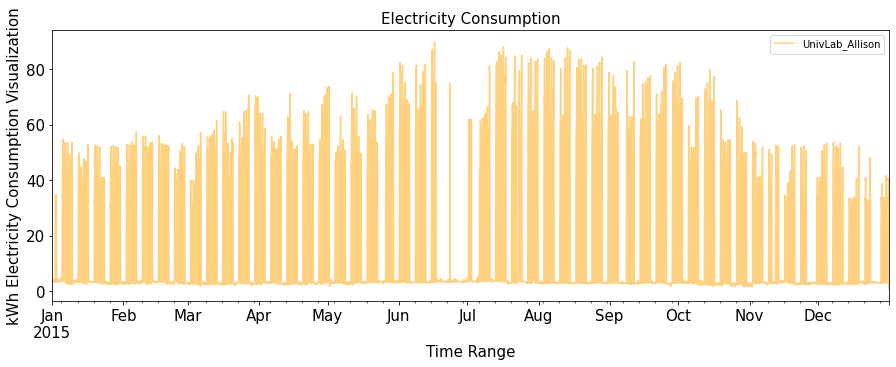

In [0]:
ua.plot(alpha=0.5, figsize=(15, 5), color='orange', fontsize=15)
plt.title("Electricity Consumption", fontsize=15)
plt.xlabel("Time Range", fontsize=15)
plt.ylabel("kWh Electricity Consumption Visualization", fontsize=15);

From June to mid-October seems to be where the most consumption took place although there were some parts within June to July where there was not much consumption. Is this due to the lab not being used (summer break)? Faulty meter reading?

In [0]:
ua_tr = ua.truncate(before='06-01-2015', after='31-07-2015')


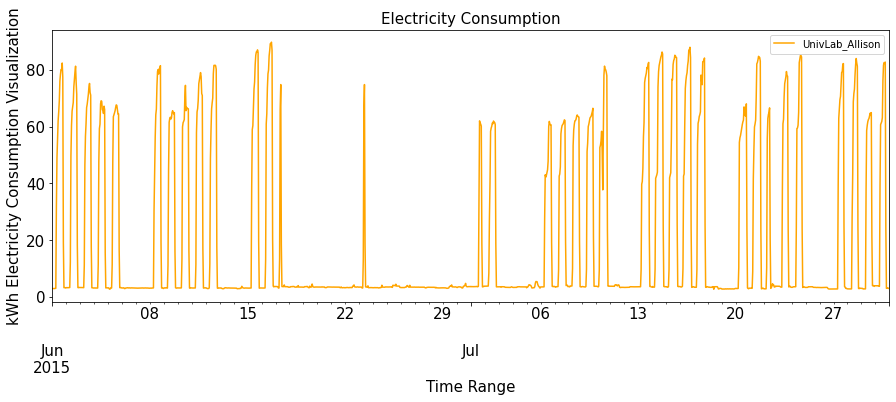

In [0]:
ua_tr.plot(color='orange', fontsize=15, figsize=(15,5))

plt.title("Electricity Consumption", fontsize=15)
plt.xlabel("Time Range", fontsize=15)
plt.ylabel("kWh Electricity Consumption Visualization", fontsize=15);



If we take a closer look, we can see that this happened within the 18th until the 30th of June.

**Weekday vs Weekend**

In [0]:
ua['Date'] = ua.index.map(lambda t: t.date())
ua['Time'] = ua.index.map(lambda t: t.time())

In [0]:
ua_pivot = pd.pivot_table(ua, values='UnivLab_Allison', index='Date', columns='Time')

In [0]:
ua_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3.79,3.68,3.61,3.61,3.48,3.28,3.81,3.47,3.46,3.67,3.65,3.88,4.05,3.90,4.15,3.90,3.95,3.63,3.50,3.36,3.58,3.50,3.34,3.27
2015-01-02,3.39,3.89,3.48,3.25,3.21,3.37,3.59,10.00,34.54,34.45,34.31,34.35,34.60,34.67,34.40,34.91,34.12,33.99,34.19,11.76,3.60,3.37,3.78,3.54
2015-01-03,3.39,3.50,3.47,3.39,3.60,3.46,3.56,3.37,3.49,3.58,3.87,3.74,4.01,4.02,4.10,3.97,4.16,3.79,3.81,3.81,3.56,3.93,3.92,3.71
2015-01-04,3.94,4.00,3.77,3.76,3.45,3.37,3.75,3.47,3.51,3.51,3.95,3.96,4.24,4.62,4.73,4.57,4.05,3.86,3.75,3.64,3.71,3.82,3.51,3.88
2015-01-05,4.07,4.10,3.75,3.62,3.58,3.40,3.48,25.05,34.08,34.20,37.65,45.72,47.73,53.23,53.88,54.85,54.32,49.97,46.25,15.30,3.78,4.32,4.16,4.04


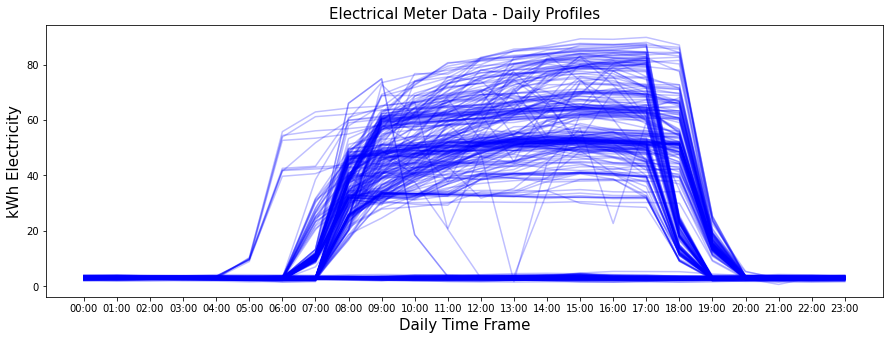

In [0]:
# Ticks are meant for 24 hours at a 3 hour interval.

ua_pivot.T.plot(legend=False, figsize=(15,5), color='b', alpha=0.25, xticks=np.arange(0, 86400, 3600))
plt.title("Electrical Meter Data - Daily Profiles", fontsize=15)
plt.xlabel("Daily Time Frame", fontsize=15)
plt.ylabel("kWh Electricity", fontsize=15);

So consumption usually starts as early as 4 AM. Peaks at 5-6 PM or close to it.

In [0]:
ua['Weekday'] = ua.index.map(lambda t: t.date().weekday())

In [0]:
ua['Weekday'].value_counts()

3    1272
6    1248
5    1248
4    1248
2    1248
1    1248
0    1248
Name: Weekday, dtype: int64

In [0]:
ua_pivot_weekday = pd.pivot_table(ua[(ua.Weekday < 5)], values='UnivLab_Allison', index='Date', columns='Time')
ua_pivot_weekend = pd.pivot_table(ua[(ua.Weekday > 4)], values='UnivLab_Allison', index='Date', columns='Time')

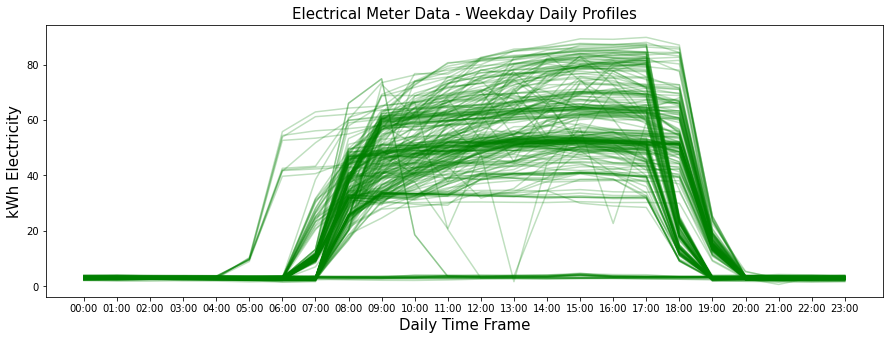

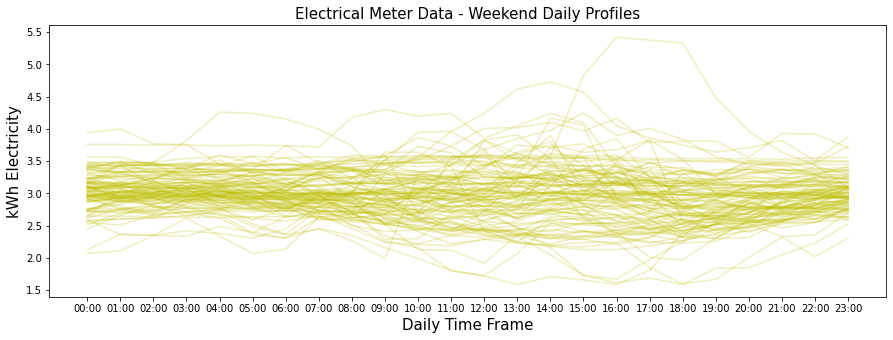

In [0]:
# Side by side comparison of weekday and weekend.
ua_pivot_weekday.T.plot(legend=False, figsize=(15,5), color='g', alpha=0.25, xticks=np.arange(0, 86400, 3600))
plt.title("Electrical Meter Data - Weekday Daily Profiles", fontsize=15)
plt.xlabel("Daily Time Frame", fontsize=15)
plt.ylabel("kWh Electricity", fontsize=15)

ua_pivot_weekend.T.plot(legend=False, figsize=(15,5), color='y', alpha=0.25, xticks=np.arange(0, 86400, 3600))
plt.title("Electrical Meter Data - Weekend Daily Profiles", fontsize=15)
plt.xlabel("Daily Time Frame", fontsize=15)
plt.ylabel("kWh Electricity", fontsize=15);


Weekdays kind of reflect what happens on our daily profiles. Weekends obviously have less usage.

**Cluster Identification**

K-Means. Here we go.

In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/edx/Chap 3/meter_data/")
k = pd.read_csv('UnivLab_Allison.csv', index_col = "timestamp", parse_dates=True)

In [0]:
k_norm = (k - k.mean()) / (k.max() - k.min()) 

In [0]:
k['Time'] = k.index.map(lambda t: t.time())
k['Date'] = k.index.map(lambda t: t.date())
k_norm['Time'] = k_norm.index.map(lambda t: t.time())
k_norm['Date'] = k_norm.index.map(lambda t: t.date())

In [0]:
dk = pd.pivot_table(k, values='UnivLab_Allison', index='Date', columns='Time', aggfunc='mean')
dk_norm = pd.pivot_table(k_norm, values='UnivLab_Allison', index='Date', columns='Time', aggfunc='mean')

In [0]:
dk_norm.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,-0.164326,-0.165561,-0.166347,-0.166347,-0.167806,-0.170051,-0.164102,-0.167919,-0.168031,-0.165673,-0.165898,-0.163316,-0.161407,-0.163091,-0.160285,-0.163091,-0.162530,-0.166122,-0.167582,-0.169153,-0.166684,-0.167582,-0.169378,-0.170164
2015-01-02,-0.168817,-0.163204,-0.167806,-0.170388,-0.170837,-0.169041,-0.166571,-0.094614,0.180869,0.179859,0.178287,0.178736,0.181543,0.182328,0.179297,0.185023,0.176154,0.174695,0.176940,-0.074856,-0.166459,-0.169041,-0.164438,-0.167133
2015-01-03,-0.168817,-0.167582,-0.167919,-0.168817,-0.166459,-0.168031,-0.166908,-0.169041,-0.167694,-0.166684,-0.163428,-0.164888,-0.161857,-0.161744,-0.160846,-0.162306,-0.160173,-0.164326,-0.164102,-0.164102,-0.166908,-0.162755,-0.162867,-0.165224
2015-01-04,-0.162642,-0.161969,-0.164551,-0.164663,-0.168143,-0.169041,-0.164775,-0.167919,-0.167469,-0.167469,-0.162530,-0.162418,-0.159275,-0.155009,-0.153774,-0.155570,-0.161407,-0.163540,-0.164775,-0.166010,-0.165224,-0.163989,-0.167469,-0.163316
2015-01-05,-0.161183,-0.160846,-0.164775,-0.166235,-0.166684,-0.168704,-0.167806,0.074336,0.175705,0.177052,0.215782,0.306374,0.328938,0.390681,0.397977,0.408866,0.402917,0.354084,0.312324,-0.035117,-0.164438,-0.158377,-0.160173,-0.161520


**Clustering Model**

This is a different form of clustering.

In [0]:
dkmatrix_norm = np.matrix(dk_norm.dropna())
centers, _ = kmeans(dkmatrix_norm, 4, iter=10000)
cluster, _ = vq(dkmatrix_norm, centers)

In [0]:
cluster_k = pd.DataFrame(cluster, columns=['ClusterNo'])

In [0]:
dailyclusters = pd.concat([dk.dropna().reset_index(), cluster_k], axis=1) 

In [0]:
dailyclusters.head()

,Date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,ClusterNo
0,2015-01-01,3.79,3.68,3.61,3.61,3.48,3.28,3.81,3.47,3.46,3.67,3.65,3.88,4.05,3.90,4.15,3.90,3.95,3.63,3.50,3.36,3.58,3.50,3.34,3.27,0
1,2015-01-02,3.39,3.89,3.48,3.25,3.21,3.37,3.59,10.00,34.54,34.45,34.31,34.35,34.60,34.67,34.40,34.91,34.12,33.99,34.19,11.76,3.60,3.37,3.78,3.54,1
2,2015-01-03,3.39,3.50,3.47,3.39,3.60,3.46,3.56,3.37,3.49,3.58,3.87,3.74,4.01,4.02,4.10,3.97,4.16,3.79,3.81,3.81,3.56,3.93,3.92,3.71,0
3,2015-01-04,3.94,4.00,3.77,3.76,3.45,3.37,3.75,3.47,3.51,3.51,3.95,3.96,4.24,4.62,4.73,4.57,4.05,3.86,3.75,3.64,3.71,3.82,3.51,3.88,0
4,2015-01-05,4.07,4.10,3.75,3.62,3.58,3.40,3.48,25.05,34.08,34.20,37.65,45.72,47.73,53.23,53.88,54.85,54.32,49.97,46.25,15.30,3.78,4.32,4.16,4.04,3


We have cluster numbers at the end!

In [0]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).sort_values()
x = pd.DataFrame(x.reset_index())
x['ClusterNoD'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [0]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNoD','Date']).T.sort_index()

In [0]:
dailyclusters.head()

ClusterNoD          0                        ...          2                      
Date       2015-01-01 2015-01-03 2015-01-04  ... 2015-10-16 2015-10-19 2015-10-26
00:00:00         3.79       3.39       3.94  ...       2.49       2.85       2.53
01:00:00         3.68       3.50       4.00  ...       2.65       2.91       2.54
02:00:00         3.61       3.47       3.77  ...       2.58       2.91       2.63
03:00:00         3.61       3.39       3.76  ...       2.10       2.93       2.70
04:00:00         3.48       3.60       3.45  ...       1.93       2.88       2.61

[5 rows x 365 columns]

**Aggregate Clusters**

In [0]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    return pydatetime

In [0]:
def clusterunstack(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = pd.to_datetime(df.Date.astype("str") + " " + df.level_2.astype("str"))
    #pd.to_datetime(df.Date  df.level_2) #map(timestampcombine, )
    df = df.dropna()
    return df

In [0]:
dailyclusters.unstack().reset_index().head()

,level_0,level_1,0
0,Date,0,2015-01-01
1,Date,2,2015-01-03
2,Date,3,2015-01-04
3,Date,9,2015-01-10
4,Date,10,2015-01-11


In [0]:
clusterunstacked = clusterunstack(dailyclusters)
clusterunstackedpivoted = pd.pivot_table(clusterunstacked, values=0, index='timestampstring', columns='ClusterNoD')

In [0]:
clusterunstackedpivoted.resample('D').sum().describe()

ClusterNoD,0,1,2,3
count,365.000000,365.000000,365.000000,365.000000
mean,26.576356,176.973212,116.448712,122.278041
std,42.997229,252.327256,263.972861,284.788349
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,67.960000,482.540000,0.000000,0.000000
max,404.940000,638.230000,841.350000,1030.320000


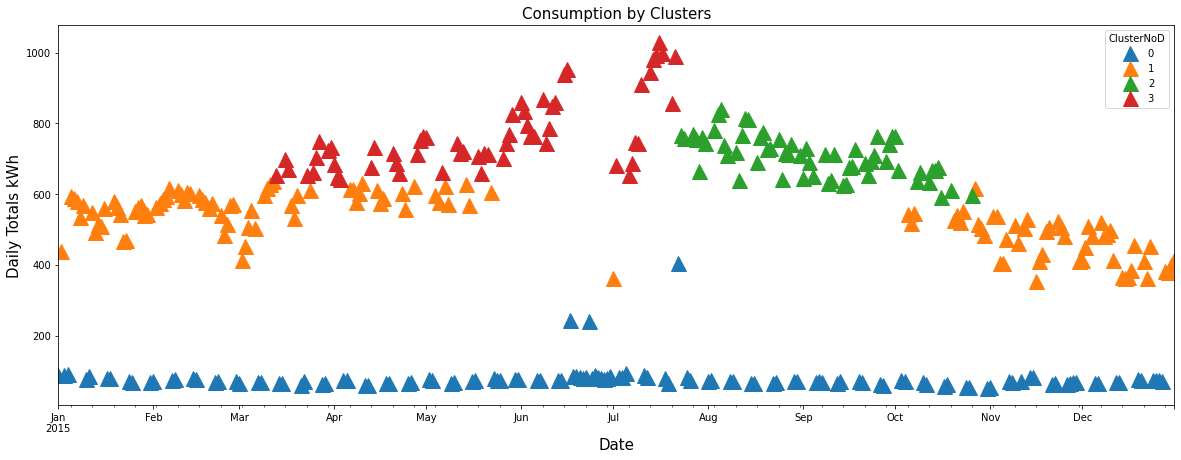

In [0]:
clusteravgplot = clusterunstackedpivoted.resample('D').sum().replace(0, np.nan).plot(style="^",markersize=15)
plt.title('Consumption by Clusters', fontsize=15)
clusteravgplot.set_ylabel('Daily Totals kWh', fontsize=15)
clusteravgplot.set_xlabel('Date', fontsize=15);

Notice the division of clusters by the day. 0 is consistent all throughout. 1 happens at the beginning and the end of the year. 2 starts on mid July all the way to November. 3 starts from March to July and consumes the most.

In [0]:
def dayscluster(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    daycluster = df.resample('D').mean().reset_index(drop=True)
    daycluster = pd.pivot_table(daycluster, values=0, index='ClusterNoD', columns='Weekday', aggfunc='count')
    daycluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return daycluster.T

In [0]:
daycluster.describe()

ClusterNoD,0,1,2,3
count,7.000000,5.000000,5.0,5.000000
mean,17.714286,24.600000,12.0,11.600000
std,23.442940,0.894427,1.0,2.073644
min,2.000000,23.000000,11.0,9.000000
25%,4.000000,25.000000,11.0,10.000000
50%,5.000000,25.000000,12.0,12.000000
75%,28.500000,25.000000,13.0,13.000000
max,52.000000,25.000000,13.0,14.000000


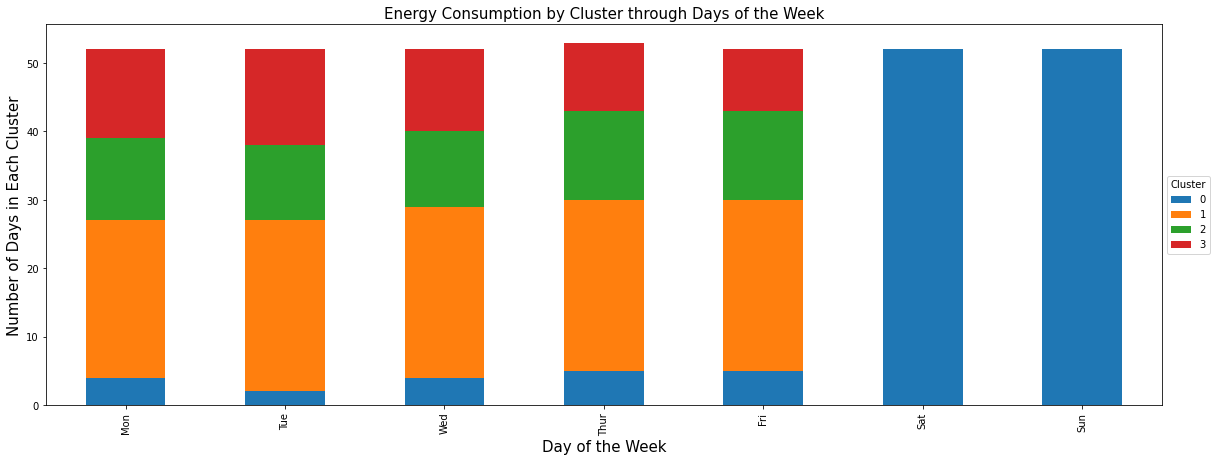

In [0]:
daycluster = dayscluster(clusterunstacked)
cplot = daycluster.plot(figsize=(20,7),kind='bar',stacked=True)
plt.title('Days of Cluster vs Day of the Week', fontsize=15)
cplot.set_ylabel('Number of Days in Each Cluster', fontsize=15)
cplot.set_xlabel('Day of the Week', fontsize=15)
cplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster');

As we can see, cluster 0 gets consumption used all the time even on weekends. On weekdays, it seems that the most days are being used by cluster 1.



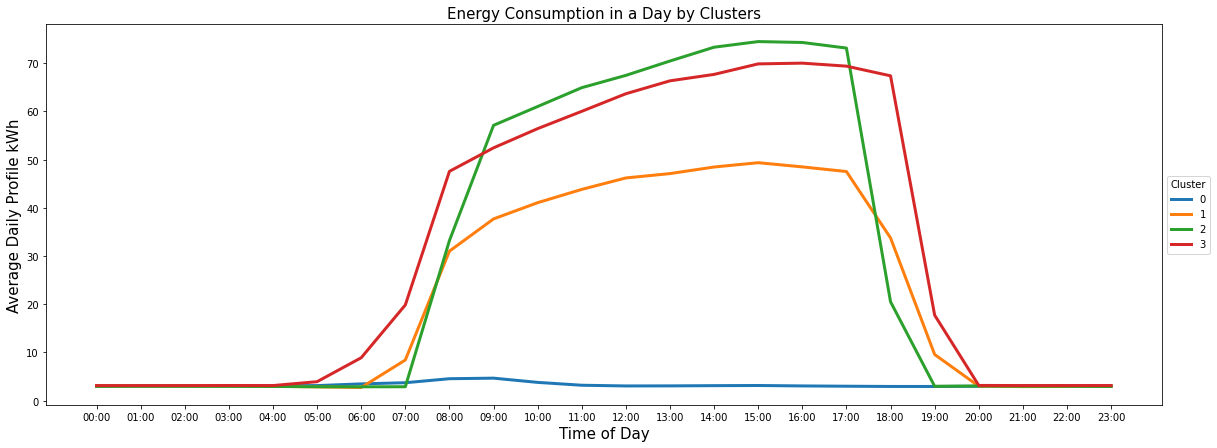

In [0]:
clusterunstackedpivoted['Time'] = clusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = clusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),linewidth=3, xticks=np.arange(0, 86400, 3600))
plt.title('Energy Consumption in a Day by Clusters', fontsize=15)
dailyprofile.set_ylabel('Average Daily Profile kWh', fontsize=15)
dailyprofile.set_xlabel('Time of Day', fontsize=15)
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

3 starts the earliest and ends the latest.

**Regression**

Let's make some predictions

In [0]:
df_prediction_data = pd.read_csv("UnivLab_Allison.csv", parse_dates=True, index_col='timestamp')

Let's grab some temperature data first.

In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/edx/Chap 3/weather_data/")
weather_data = pd.read_csv("weather0.csv", index_col='timestamp', parse_dates=True)

In [0]:
weather_hourly = weather_data.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

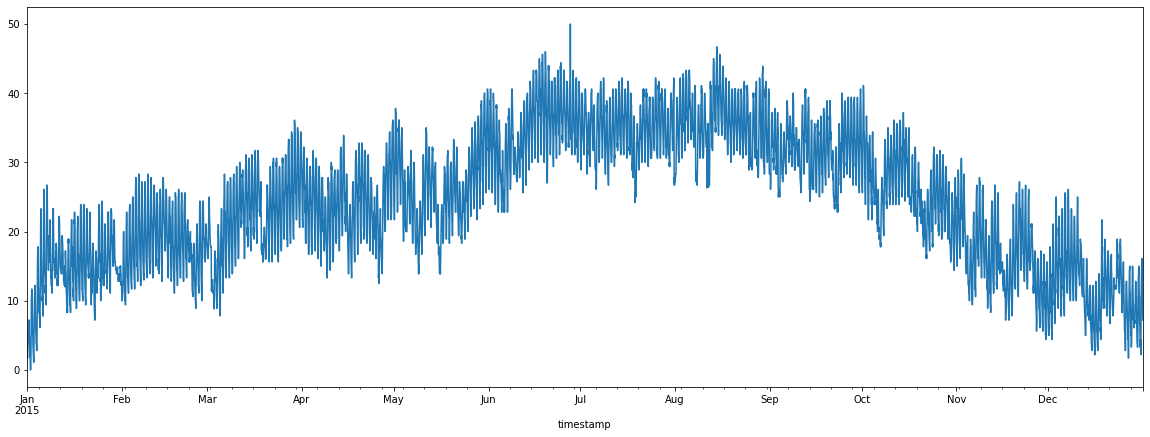

In [0]:
temperature = weather_hourly_nooutlier_nogaps["TemperatureC"]
temperature.plot();

Train and Test Data. Out of curiosity I want to know what the prediction for the period of June would be as compared to actual. 

In [0]:
training_months = [3,4,5]
test_months = [6]

In [0]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]

In [0]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2015-03-01 00:00:00 to 2015-05-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivLab_Allison  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


In [0]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2015-06-01 00:00:00 to 2015-06-30 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivLab_Allison  720 non-null    float64
dtypes: float64(1)
memory usage: 11.2 KB


**Encoding Variables**

In [0]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), pd.get_dummies(trainingdata.index.dayofweek), 
                            pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()

In [0]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17.2
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16.7
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16.7
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16.1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16.1


**Testing with the most basic regressor**

In [0]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));

In [0]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

Note for future reference: This data needs to be normalized since temperature has higher values?

**Prediction Time**

In [0]:
predictions = model.predict(test_features)

In [0]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [0]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [0]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2015-06-01 00:00:00,2.94,62.3520
2015-06-01 01:00:00,2.93,25.2900
2015-06-01 02:00:00,2.91,33.8545
2015-06-01 03:00:00,2.93,14.1920
2015-06-01 04:00:00,2.95,30.0540


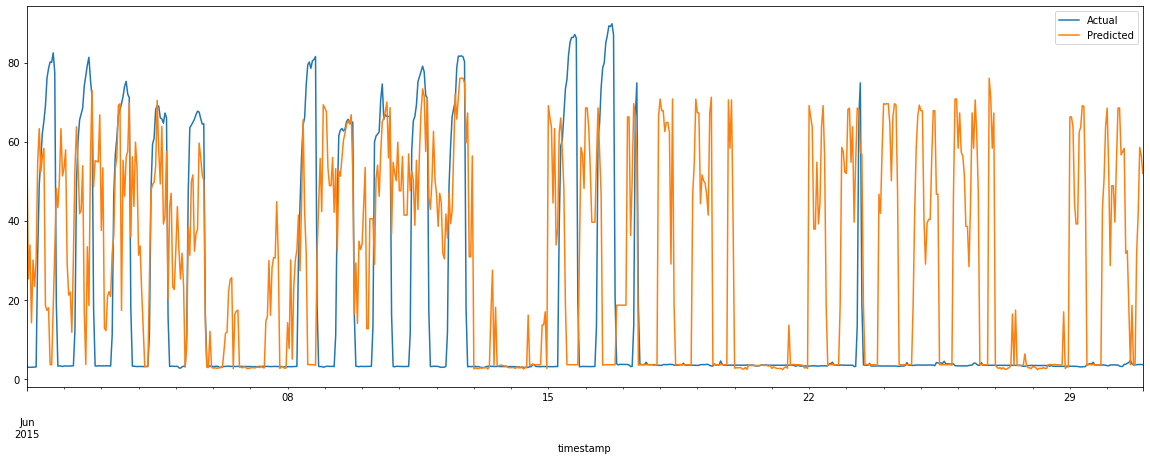

In [0]:
predicted_vs_actual.plot();

There's really something going on within the period of the 18th all the way to the 30th! Need to check with the business.


Have to review clustering and regression and do some min max scaling before modeling them.